# Predicting global innovation index using regression models

## Data loading and preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.feature_selection import f_regression
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, ElasticNetCV
from sklearn.feature_selection import RFE
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler

In [2]:
merged = pd.read_csv('../../data/converted/merged.csv')

Including the global happiness index into the merged dataset

In [3]:
# including happiness index
happy = pd.read_csv('../../data/converted/happiness_index.csv')
happy['year'] = 2019
merged = merged.merge(happy, on=['country_iso', 'year'], how='outer', sort=True)

In [4]:
pd.Series(merged.columns)

0                                                  year
1                                     gii_human_capital
2                                           country_iso
3                                   gii_domestic_credit
4                                  mobile_subscriptions
5                        broadband_subscriptions_per100
6                              gii_ict_services_imports
7                     diversity_ethnicFractionalization
8                 diversity_linguisticFractionalization
9                  diversity_religiousFractionalization
10                                        literacy_rate
11                                      electrification
12                          gii_scientific_publications
13                                          book_titles
14                                            rd_in_gdp
15                             creative_svc_audiovisual
16    creative_svc_other_personal_cultural_recreational
17         creative_svc_advertising_mktresearch_

In [5]:
df = merged.copy()

The merged dataset has data for many years. We will only consider data from 2015 to now. For each country and feature, we will consider the last value available.

In [6]:
df.drop(df[df.year < 2015].index, inplace = True)

In [7]:
df_last = df.groupby('country_iso', as_index=False).last()

In [8]:
# calculate feature mean over all years available (using mean to include outlier effects) 
#df_mean = df.groupby('country_iso', as_index=False).mean()
# remove year column
df_last.drop(['year'], axis = 1, inplace = True)

We have to limit the prediction to the set of countries for which we have the global index available.

In [9]:
df_last.dropna(subset=['gii_innovation_output'], inplace=True)

In [10]:
df_last.count()

country_iso                                          129
gii_human_capital                                    129
gii_domestic_credit                                  126
mobile_subscriptions                                 129
broadband_subscriptions_per100                       129
gii_ict_services_imports                             128
diversity_ethnicFractionalization                    127
diversity_linguisticFractionalization                127
diversity_religiousFractionalization                 127
literacy_rate                                         78
electrification                                      129
gii_scientific_publications                          128
book_titles                                           13
rd_in_gdp                                             99
creative_svc_audiovisual                               0
creative_svc_other_personal_cultural_recreational      0
creative_svc_advertising_mktresearch_polling           0
creative_svc_architectural_engi

Some of the features do not have enough data. We will limit our analysis to the features that have values for most of the countries of the global index. 

In [11]:
to_drop = df_last.columns[df_last.columns.str.contains('creative_svc_')].values
to_drop = np.append(to_drop,['book_titles', 'total_hospital_density_per_100k', 'cultural_occupation', 'literacy_rate', 'gii_stem_assessment', 'poverty_ratio'])
df_subset = df_last.drop(columns=to_drop)
df_subset.count()

country_iso                              129
gii_human_capital                        129
gii_domestic_credit                      126
mobile_subscriptions                     129
broadband_subscriptions_per100           129
gii_ict_services_imports                 128
diversity_ethnicFractionalization        127
diversity_linguisticFractionalization    127
diversity_religiousFractionalization     127
electrification                          129
gii_scientific_publications              128
rd_in_gdp                                 99
rural_population                         126
school_enrollment_tertiary               111
gii_creative_services                    119
gii_rule_of_law                          129
population                               129
mortality_rate                           128
secure_internet_servers                  129
gii_institutions                         129
gii_top_level_domains                    129
gii_patent_applications                  126
feature_fi

In [12]:
df_sample = df_subset.dropna(axis=0)
df_sample.count()

country_iso                              51
gii_human_capital                        51
gii_domestic_credit                      51
mobile_subscriptions                     51
broadband_subscriptions_per100           51
gii_ict_services_imports                 51
diversity_ethnicFractionalization        51
diversity_linguisticFractionalization    51
diversity_religiousFractionalization     51
electrification                          51
gii_scientific_publications              51
rd_in_gdp                                51
rural_population                         51
school_enrollment_tertiary               51
gii_creative_services                    51
gii_rule_of_law                          51
population                               51
mortality_rate                           51
secure_internet_servers                  51
gii_institutions                         51
gii_top_level_domains                    51
gii_patent_applications                  51
feature_films_produced          

We are restricting our analysis to a sample of 51 countries, from a universe of 129 (number of countries covered by the Global Innovation Index). This should be enough to prove that the regression model is accurate.

In [13]:
target = df_sample[['gii_innovation_output']]
feats = df_sample.drop(columns=['gii_innovation_output', 'global_innovation_index', 'country_iso'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.20, random_state=42)

In [15]:
scaler = StandardScaler()
feats_scaled = scaler.fit_transform(feats)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Regression Models

In [16]:
models = ['random_forest', 'lr', 'lr_lasso', 'lr_rfe']
results = pd.DataFrame(data={'mae': [0,0,0,0], 'r2_score': [0,0,0,0]}, index=models)

### Random Forest

In [17]:
rf_model = RandomForestRegressor(max_depth=5, random_state=0)
rf_model.fit(X_train, y_train)

/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [18]:
y_predict = rf_model.predict(X_test)

In [19]:
mean_absolute_error(y_test, y_predict)

3.9479629378197556

In [20]:
y_predict_insample = rf_model.predict(X_train)

In [21]:
mean_absolute_error(y_train, y_predict_insample)

1.3839143795093805

In [22]:
r2_score(y_test, y_predict)

0.7113936488603474

In [23]:
r2_score(y_train, y_predict_insample)

0.9792582834648293

In [24]:
results.loc['random_forest', 'mae'] = mean_absolute_error(y_test, y_predict)
results.loc['random_forest', 'r2_score'] = r2_score(y_test, y_predict)

### Linear Regression

In [25]:
linear = LinearRegression()
linear.fit(X_train, y_train)
y_predict = linear.predict(X_test)
mean_absolute_error(y_test, y_predict)

5.615887401977311

In [26]:
r2_score(y_test, y_predict)

0.32088624705436275

In [27]:
feats_nonneg = feats.copy()
feats_nonneg['foreign_investment'] = feats_nonneg['foreign_investment'] + abs(feats_nonneg['foreign_investment'].min())
feats_nonneg['gii_rule_of_law'] = feats_nonneg['gii_rule_of_law'] + abs(feats_nonneg['gii_rule_of_law'].min())
feats_nonneg.describe().loc['min',:]

gii_human_capital                            11.200000
gii_domestic_credit                          16.100000
mobile_subscriptions                         86.942563
broadband_subscriptions_per100                1.022782
gii_ict_services_imports                      0.000000
diversity_ethnicFractionalization             0.039400
diversity_linguisticFractionalization         0.000000
diversity_religiousFractionalization          0.000000
electrification                              84.400000
gii_scientific_publications                   0.600000
rd_in_gdp                                     0.118230
rural_population                              0.865000
school_enrollment_tertiary                   13.134280
gii_creative_services                         0.000000
gii_rule_of_law                               0.000000
population                               353574.000000
mortality_rate                                1.400000
secure_internet_servers                      35.113531
gii_instit

In [28]:
scores, pvalues = f_regression(feats, target)

/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
scores

array([7.88841617e+01, 1.48626046e+01, 2.99926000e-01, 8.47694998e+01,
       1.24447188e+01, 5.11513675e+00, 3.79504214e-01, 4.37034269e+00,
       4.40614730e+00, 2.34256782e+01, 6.96906777e+01, 6.63041969e+00,
       5.90481611e+00, 9.51048843e+00, 1.05971798e+02, 7.65418621e-01,
       3.05520906e+01, 5.05753472e+01, 1.17565369e+02, 5.42842172e+01,
       8.63372112e+01, 1.62834091e-03, 1.29283281e+02, 1.54493855e+00,
       8.49489812e+01, 4.87580887e-01, 3.54425886e+01, 3.59326092e+01,
       4.25822703e+01, 5.18558356e+01, 1.63536320e+00, 5.63183778e+01,
       5.66323777e+01, 4.56192572e+01])

In [30]:
results.loc['lr', 'mae'] = mean_absolute_error(y_test, y_predict)
results.loc['lr', 'r2_score'] = r2_score(y_test, y_predict)

### Linear Regression using Lasso

In [31]:
lr_lasso = Lasso()
lr_lasso.fit(X_train, y_train)
y_predict = lr_lasso.predict(X_test)
mean_absolute_error(y_test, y_predict)

3.1641820308820248

In [32]:
r2_score(y_test, y_predict)

0.8140749697533981

In [33]:
results.loc['lr_lasso', 'mae'] = mean_absolute_error(y_test, y_predict)
results.loc['lr_lasso', 'r2_score'] = r2_score(y_test, y_predict)

In [34]:
features = pd.Series(lr_lasso.coef_, index=feats.columns.values)

In [35]:
features.sort_values(ascending=False)

gii_patent_families                      3.349284
gii_research_talent_in_business          1.664069
broadband_subscriptions_per100           1.263226
gii_university_industry                  1.227880
secure_internet_servers                  1.166649
gii_top_level_domains                    0.989628
gii_wikipedia_edits                      0.968449
gii_institutions                         0.832242
gii_ict_services_imports                 0.340004
gii_creative_goods                       0.146993
gii_human_capital                        0.095480
rd_in_gdp                                0.000000
gii_scientific_publications              0.000000
electrification                          0.000000
diversity_ethnicFractionalization       -0.000000
diversity_religiousFractionalization     0.000000
diversity_linguisticFractionalization    0.000000
school_enrollment_tertiary               0.000000
mobile_subscriptions                    -0.000000
gii_domestic_credit                      0.000000


### Linear Regression using RFECV

/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal number of features : 3


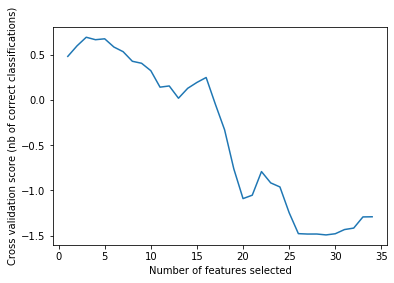

In [36]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
X = feats_scaled
y = target
lr_rfecv = LinearRegression()
rfecv = RFECV(estimator=lr_rfecv, step=1, scoring='r2')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [37]:
rfecv.grid_scores_

array([ 0.4841935 ,  0.60072269,  0.69621736,  0.66885298,  0.67897181,
        0.58776114,  0.53624628,  0.4300599 ,  0.40804527,  0.3260323 ,
        0.14342698,  0.15683298,  0.02085164,  0.13057986,  0.19574907,
        0.25045257, -0.04545743, -0.32874102, -0.76140921, -1.09068439,
       -1.0530136 , -0.79142387, -0.91659635, -0.96169763, -1.2468117 ,
       -1.47876698, -1.48325335, -1.48290267, -1.49286952, -1.47995787,
       -1.4335049 , -1.41718619, -1.29360443, -1.29194221])

### Linear Regression using RFE (recursive feature elimination)

In [38]:
X = feats_scaled
y = target
lr_rfe = LinearRegression()
#Initializing RFE model
rfe = RFE(lr_rfe)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
lr_rfe.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True False  True  True False False  True False False  True  True
 False False False  True False  True False  True  True  True  True False
  True  True False False  True False False  True False False]
[ 1  1 16  1  1 12 18  1  4  3  1  1 11  9 15  1 10  1 14  1  1  1  1  6
  1  1  8 17  1  2  7  1 13  5]


/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
#no of features
nof_list=np.arange(1,len(feats.columns.values))            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(lr_rfe,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    lr_rfe.fit(X_train_rfe,y_train)
    score = lr_rfe.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A 

Optimum number of features: 2
Score with 2 features: 0.856095


/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A 

In [40]:
cols = list(feats.columns)
lr_rfe_final = LinearRegression()
#Initializing RFE model
rfe = RFE(lr_rfe_final, 2)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
lr_rfe_final.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['broadband_subscriptions_per100', 'gii_patent_families'], dtype='object')


/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
lr_rfe_final.coef_

array([[4.7564479 , 6.57747839]])

In [42]:
rfe.support_

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False])

In [43]:
pd.Series(lr_rfe_final.coef_[0], index=selected_features_rfe).apply(abs).sort_values(ascending=False)

gii_patent_families               6.577478
broadband_subscriptions_per100    4.756448
dtype: float64

In [44]:
selected_features_rfe

Index(['broadband_subscriptions_per100', 'gii_patent_families'], dtype='object')

In [45]:
predict = lr_rfe_final.predict(pd.DataFrame(X, columns=feats.columns)[selected_features_rfe])

In [46]:
mean_absolute_error(y, predict)

3.7598137187415595

In [47]:
predict_test = lr_rfe_final.predict(pd.DataFrame(X_test, columns=feats.columns)[selected_features_rfe])

In [48]:
mean_absolute_error(y_test, predict_test)

3.4615425060876475

In [49]:
r2_score(y_test, predict_test)

0.8588715527447703

In [50]:
results.loc['lr_rfe', 'mae'] = mean_absolute_error(y_test, predict_test)
results.loc['lr_rfe', 'r2_score'] = r2_score(y_test, predict_test)

### Selecting best model

In [51]:
results

,mae,r2_score
random_forest,3.947963,0.711394
lr,5.615887,0.320886
lr_lasso,3.164182,0.814075
lr_rfe,3.461543,0.858872


Our two best performing models are the Lasso linear model and the linear regression using RFE. Let's take a look at the used features and its coefficients for the first one:

In [73]:
coefs = pd.Series(lr_lasso.coef_, index=feats.columns)
coefs.drop(coefs[coefs==0.0].index, inplace=True)
coefs.sort_values(ascending=False)

gii_patent_families                3.349284
gii_research_talent_in_business    1.664069
broadband_subscriptions_per100     1.263226
gii_university_industry            1.227880
secure_internet_servers            1.166649
gii_top_level_domains              0.989628
gii_wikipedia_edits                0.968449
gii_institutions                   0.832242
gii_ict_services_imports           0.340004
gii_creative_goods                 0.146993
gii_human_capital                  0.095480
mortality_rate                    -0.012216
ease_of_business                  -0.322155
dtype: float64

The only thing that can be highlighted here is that the ease of business has a negative effect on the innovation index. Besides that, the used features are a mix among creativity, economic and educational factors. Lets take a look at the second model, the linear regression using RFE:

In [75]:
coefs = pd.Series(lr_rfe_final.coef_[0], index=selected_features_rfe)
coefs.drop(coefs[coefs==0.0].index, inplace=True)
coefs.sort_values(ascending=False)

gii_patent_families               6.577478
broadband_subscriptions_per100    4.756448
dtype: float64

That is surprising. The linear regression model was able to predict, with a reasonable accuracy, using only two factors: number of patent families and broadband subscriptions. Let's predict for all countries and check the differences:

In [94]:
df_prediction = df_sample[['country_iso', 'gii_innovation_output']]
rfe_predict = lr_rfe_final.predict(X_rfe)
df_prediction['rfe_prediction'] = rfe_predict

/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [97]:
lasso_predict = lr_lasso.predict(feats_scaled)
df_prediction['lasso_prediction'] = lasso_predict

/Users/ricardostamato/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


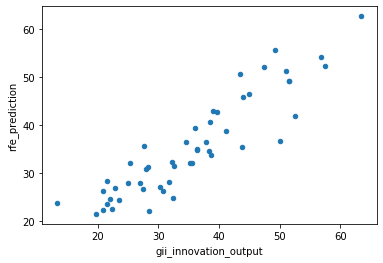

In [98]:
df_prediction.plot.scatter('gii_innovation_output', 'rfe_prediction')

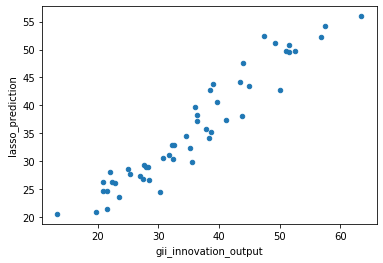

In [99]:
df_prediction.plot.scatter('gii_innovation_output', 'lasso_prediction')

In [101]:
df_prediction.to_csv('lr_predictions.csv')

In [102]:
mean_absolute_error(df_prediction.gii_innovation_output, df_prediction.lasso_prediction)

2.805757839906855

In [103]:
mean_absolute_error(df_prediction.gii_innovation_output, df_prediction.rfe_prediction)

3.7598137187415595

Looking at the scatter plots and the final Mean Absolute Error (considering all countries), we can see that the first model, Lasso, performs a lot better.

In [60]:
df_prediction.to_csv('linear_regression.csv')

## Conclusions

We could find a linear regression model which could predict a country's innovation index with reasonable accuracy. However, the set of features used to predict does not show any special insight: they are a combination of economic, creativity and educational factors.

It is possible to predict the index using a very smaller set of features, particularly the number of patent families and broadband subscriptions, but the prediction is less accurate than the one using a more, mixed factors.